In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


dataA_Parzen = pd.read_csv("dataA_Parzen.csv").to_numpy()
dataB_test   = pd.read_csv("dataB_test.csv").to_numpy()
dataB_train  = pd.read_csv("dataB_train.csv").to_numpy()

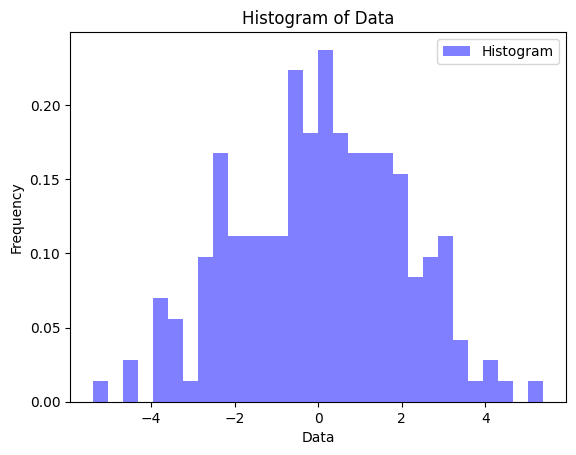

In [ ]:
def hypercube_window(u, center, radius): #(1)

    dimensions = len(u)
    distance = np.abs(u - center) / radius

    # Apply element-wise minimum
    result = np.minimum(distance, np.ones(dimensions))

    # φ(u) is 1 if all dimensions are within the hypercube, 0 otherwise
    return np.prod(result) / radius


def gaussian_window(u, center, sigma): #(2)

  squared_distance = np.sum((u - center)**2)  # Sum of squared distances in each dimension
  result = np.exp(-squared_distance / (2 * sigma**2))

  return result


def kernel_estimator(x, c, h, kernel_type): #(3)

    if kernel_type == 'hypercube':
        return hypercube_window(x, c, h)  # h/2 is the radius for the hypercube
    elif kernel_type == 'Gaussian':
        return gaussian_window(x, c, h)  # h acts as a scaling factor for the Gaussian's spread


def density_parzen(data, x, c, h, kernel_type): #(4)

    k = 0
    for data_point in data:
        window_value = kernel_estimator(data_point, c, h, kernel_type)
        k += window_value

    volume = h if kernel_type == 'hypercube' else np.sqrt(2 * np.pi * h**2)  # Adjust volume calculation

    return k / (len(data) * volume)



# Generate data from N(0, 4)
data = dataA_Parzen

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.5, color='b', label='Histogram')
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.legend()
plt.show()

h_values = np.arange(0.2, 10, 0.1)
mse_hypercube = []
mse_gaussian = []

for h in h_values:
    likelihood_pred_hypercube = [density_parzen(data, x, c=0, h=h, kernel_type='hypercube') for x in data]
    likelihood_true = norm.pdf(data, loc=0, scale=2)
    mse_hypercube.append(np.mean((likelihood_pred_hypercube - likelihood_true)**2))

    likelihood_pred_gaussian = [density_parzen(data, x, c=0, h=h, kernel_type='Gaussian') for x in data]
    mse_gaussian.append(np.mean((likelihood_pred_gaussian - likelihood_true)**2))

optimal_h_hypercube = h_values[np.argmin(mse_hypercube)]
optimal_h_gaussian = h_values[np.argmin(mse_gaussian)]

print("Best h (Hypercube):", optimal_h_hypercube)
print("Best h (Gaussian):", optimal_h_gaussian)

plt.plot(h_values, mse_hypercube, label='Hypercube')
plt.plot(h_values, mse_gaussian, label='Gaussian')
plt.xlabel('h (Window Width)')
plt.ylabel('MSE')
plt.title('MSE vs. h for Hypercube and Gaussian Kernels')
plt.legend()
plt.show()

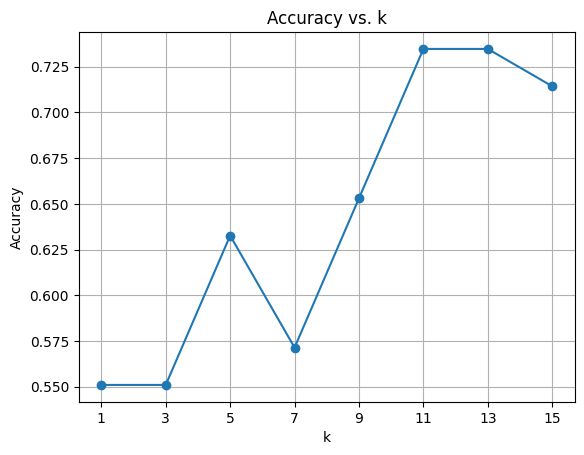

Best k: 11
Best accuracy: 0.7346938775510204


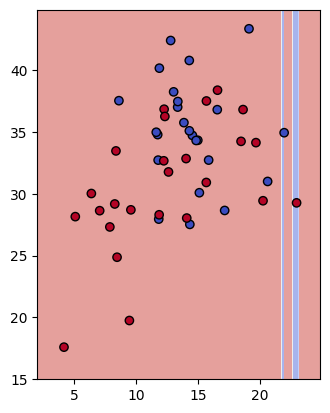

In [48]:
def euclidean_distances(x, dataset):

    differences = dataset - x  # Vectorized subtraction for efficiency
    squared_differences = differences ** 2
    sum_of_squares = np.sum(squared_differences, axis=1)  # Sum along rows
    distances = np.sqrt(sum_of_squares)

    return distances


def find_k_nearest_neighbors(x, dataset, k):

    distances = euclidean_distances(x, dataset)
    sorted_indices = np.argsort(distances)  # Indices that would sort the distances

    k_nearest_indices = sorted_indices[:k]
    k_nearest_neighbors = dataset[k_nearest_indices]

    return k_nearest_neighbors, k_nearest_indices


def knn_classify(train_data, test_data, k):

    # Extract features and labels from training data
    train_features = train_data[:, :-1]  # Exclude the last column (label)
    train_labels = train_data[:, -1]     # Last column (label)

    # Initialize arrays to store probabilities
    probabilities_class_0 = np.zeros(len(test_data))
    probabilities_class_1 = np.zeros(len(test_data))

    # Iterate over test data
    for i, test_sample in enumerate(test_data):
        # Find k nearest neighbors
        k_neighbors, nearest_indices = find_k_nearest_neighbors(test_sample[:-1], train_features, k)

        # Get labels of k nearest neighbors
        k_labels = train_labels[nearest_indices]

        # Count occurrences of each class among neighbors
        class_0_count = np.count_nonzero(k_labels == 0)
        class_1_count = np.count_nonzero(k_labels == 1)

        # Calculate probabilities for class 0 and class 1
        probabilities_class_0[i] = class_0_count / k
        probabilities_class_1[i] = class_1_count / k

    return probabilities_class_0, probabilities_class_1


# Define the range of k values
k_values = np.arange(1, 16, 2)  # From 1 to 15 with step 2

# Calculate accuracy for each value of k
accuracies = []

test_data  = dataB_test
train_data = dataB_train

for k in k_values:
    # Get probabilities for each class using k-NN classifier
    probabilities_class_0, probabilities_class_1 = knn_classify(train_data, test_data, k)

    # Predicted labels based on probabilities
    predicted_labels = np.argmax(np.column_stack((probabilities_class_0, probabilities_class_1)), axis=1)

    # True labels from test data
    true_labels = test_data[:, -1]

    # Calculate accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    accuracies.append(accuracy)

# Find the best k with the highest accuracy
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

# Plot results
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

print("Best k:", best_k)
print("Best accuracy:", best_accuracy)

optimal_k = best_k

x_min, x_max = 2, 25
y_min, y_max = 15, 45
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
np.arange(y_min, y_max, 0.1))
Z = np.array([knn_classify(train_data, np.array([x, y]).reshape(1, -1), optimal_k)[1]
              for x, y in zip(xx.ravel(), yy.ravel())])
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(train_data[:, 0], train_data[:, 1],
c=train_data[:, 2], cmap=plt.cm.coolwarm, edgecolors='k')
plt.gca().set_aspect('equal')
plt.show()